<a href="https://colab.research.google.com/github/YanaAbakumova/Neural_networks/blob/lesson_7/Lesson7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Практическое задание


<ol>
    <li>Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?
    </li> 
    <li>Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.
    </li>

</ol>

## SqueezeDet.

Алгоритм создан в 2016 году для решения задачи детектирования объектов, в частности, для беспилотного вождения, где требуется детектирование объектов в реальном времени. Алгоритм является одностадийным детектором, как YOLO или SSD. Модель является полностью сверточной. 

#### Преимущества:
- Скорость
- Экономия ресурсов
- Маленький размер модели

#### Алгоритм

![squeezedet.jpg](https://theintelligenceofinformation.files.wordpress.com/2017/03/squeezedetfig1.jpg)

Сначала используется набор сверточных фильтров для создания многомерной карты признаков низкого разрешения для поданного на вход изображения. Затем используется ConvDet - сверточный слой, который принимает на вход карту признаков и определяет множество местоположений объектов (bounding box) и предсказывает их категории. Каждое местоположение объекта соотносится со значениями С+1, где С - это вероятности классов и 1 - значение уверенности в том, что в данной области содержится объект (confidence score). 
После этого местоположения объектов фильтруется (остается N местоположений с самым высоким значением confidence score) и определяются итоговые предсказания. Для фильтрации используется NMS (Non Maximum Supression).

 Сверточные слои в SqueezeDet полностью связаны (FCN). Последний сверточный слой выводит сетку (H×W×Channels), затем используется пуллинг, чтобы превратить ее в вектор (1х1хChannels) предсказанных вероятностей классов. 

 Если в двухстадийных детекторах слой, подобный ConvDet, отвечает только за определение мест объектов, то в одностадийных на этот слой также возложена задача классификации. Идея такого алгоритма заимствована у Yolo с тем отличием, что Squeezenet для геренации десятков тысяч предположений о местах расположения объектов требуется гораздо меньше параметров. 
  Для оценки работы модели используется комплексная функция потерь: 1я ее часть отвечает за сравнение bounding boxов с реальными местоположениями объектов, 2я часть - за соответствие confidence score наличию объекта, 3я часть - кросс-энтропия для классификации.

#### Источники:
https://arxiv.org/pdf/1612.01051.pdf

https://theintelligenceofinformation.wordpress.com/2017/03/02/introducing-squeezedet-low-power-fully-convolutional-neural-network-framework-for-autonomous-driving/

#### Вывод:
модель кажется наиболее подходящей для ситуаций, когда важнее всего скорость, не требует большой оперативной памяти и занимает относительно мало места, т.е. для ее запуска системные требования более низкие. Как и другие одностадийные модели, она менее точная, чем двустадийные, поэтому если для проекта важнее всего точность, имеется много похожих мелких объектов, лучше использовать другой алгоритм.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import os

import tensorflow as tf
import tensorflow_hub as hub
import time

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
file = '/content/drive/MyDrive/street.jpg'

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def run_detector(detector, path, max_boxes):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes)
  for i, obj in enumerate(zip(result["detection_class_entities"], result["detection_scores"]), 0):
    if i < max_boxes:
      print(obj)
    else:
      break

  display_image(image_with_boxes)
  return result

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

  #  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

(b'Car', 0.55689293)
(b'Car', 0.3072093)
(b'Footwear', 0.28983396)
(b'Footwear', 0.26928145)
(b'Footwear', 0.26813436)
(b'Footwear', 0.26689026)
(b'Car', 0.24830621)
(b'Footwear', 0.23248792)
(b'Footwear', 0.22432396)
(b'Footwear', 0.22052076)


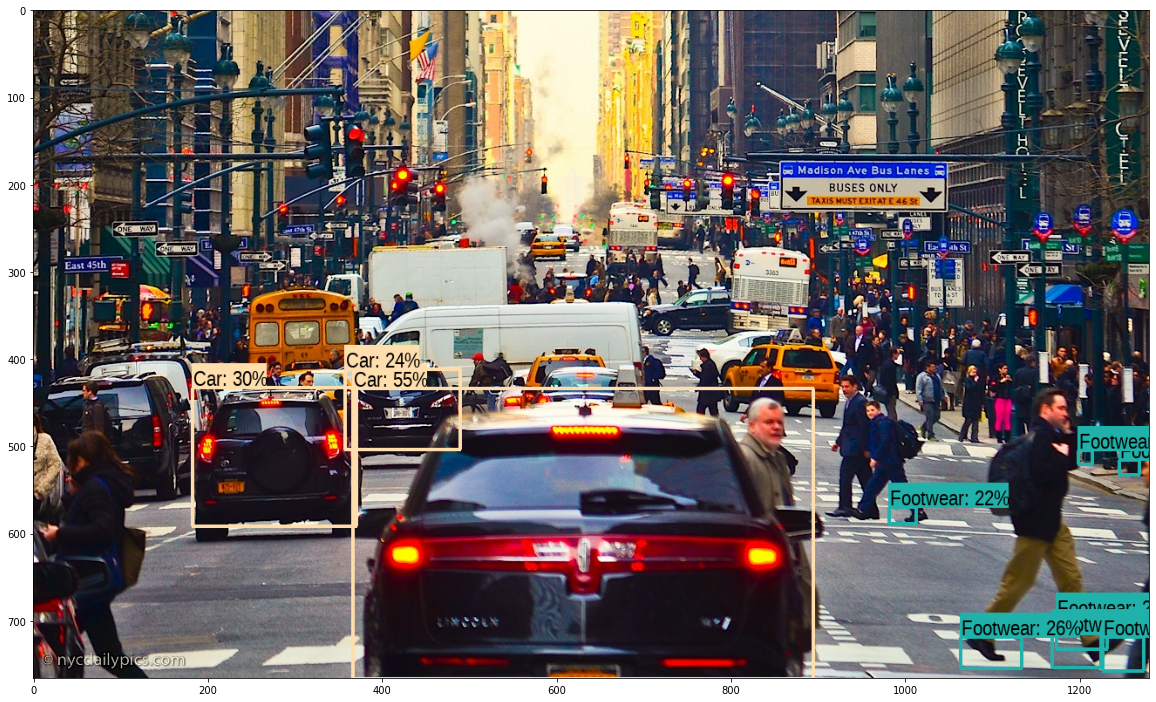

In [ ]:
result = run_detector(detector, file, 10)

(b'Car', 0.55689293)
(b'Car', 0.3072093)
(b'Footwear', 0.28983396)
(b'Footwear', 0.26928145)
(b'Footwear', 0.26813436)
(b'Footwear', 0.26689026)
(b'Car', 0.24830621)
(b'Footwear', 0.23248792)
(b'Footwear', 0.22432396)
(b'Footwear', 0.22052076)
(b'Footwear', 0.21698949)
(b'Person', 0.2148068)
(b'Footwear', 0.20285904)
(b'Person', 0.18754724)
(b'Footwear', 0.18364203)
(b'Footwear', 0.17844397)
(b'Footwear', 0.17292705)
(b'Wheel', 0.17006052)
(b'Footwear', 0.16908967)
(b'Person', 0.16840935)
(b'Wheel', 0.1641446)
(b'Person', 0.16227943)
(b'Building', 0.16175213)
(b'Footwear', 0.15866038)
(b'Footwear', 0.15745285)
(b'Man', 0.15478972)
(b'Person', 0.15437716)
(b'Wheel', 0.15296814)
(b'Wheel', 0.15245464)
(b'Person', 0.15107495)
(b'Wheel', 0.14805388)
(b'Footwear', 0.14697978)
(b'Footwear', 0.14529812)
(b'Person', 0.14512774)
(b'Car', 0.14505354)
(b'Footwear', 0.14482647)
(b'Footwear', 0.14287072)
(b'Building', 0.14200145)
(b'Person', 0.13977474)
(b'Building', 0.13804144)
(b'Car', 0.1363369)

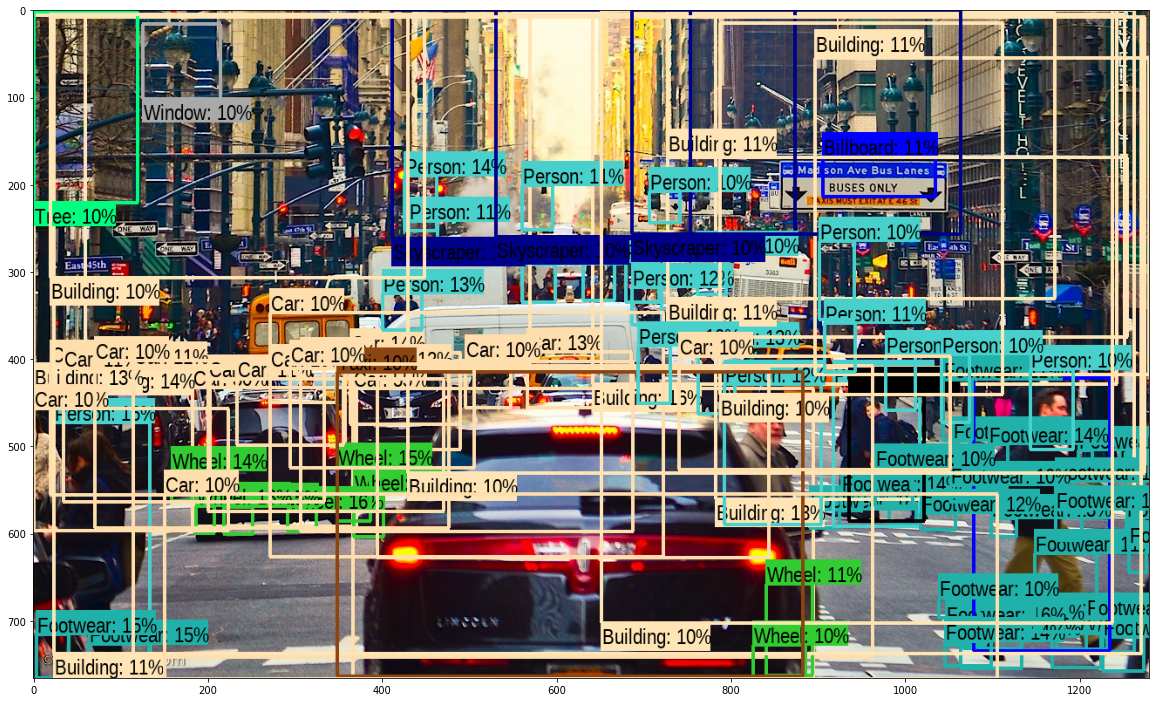

In [ ]:
result2 = run_detector(detector, file, 100)